### Linear Regression Model

In [1]:
import numpy as np
import pandas as pd
import quandl
import math
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import style
import datetime
import pickle

style.use('ggplot')


In [2]:
# Get data from quandl
df = quandl.get('WIKI/GOOGL')

In [3]:
# Select features
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

# Create a new feature
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100

# Define new data frame
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]


In [4]:
df.fillna(-99999, inplace=True)

In [5]:
# label column
forecast_col = 'Adj. Close'

# forecast into the future (e.g., 1% of the df length)
forecast_out = int(math.ceil(0.1*len(df)))

# add label column (we shift it up)
df['label'] = df[forecast_col].shift(-forecast_out)


Train and Test

In [6]:
# Separate X values into train-test and then prediction 
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)
y = np.array(df['label'])


C:\Users\Christoph\AppData\Local\Temp\ipykernel_16332\1432741769.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop(['label'], 1))


In [7]:
# Create train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [8]:
# Classifier
clf = LinearRegression()
#clf = svm.SVR(kernel='poly')
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)


0.8649956143344089


In [9]:
# Save the trained classifier by pickling
with open('LinearRegression.pickle', 'wb') as f:
    pickle.dump(clf, f)


In [10]:
# Read the classifier back in
pickle_in = open('LinearRegression.pickle', 'rb')
clf = pickle.load(pickle_in)


Prediction

In [11]:
forecast_set = clf.predict(X_lately)
#print(forecast_set)

In [12]:
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day


In [13]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
    

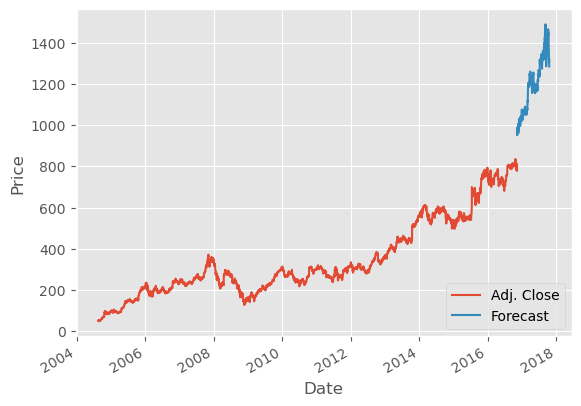

In [14]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
